In [2]:
import numpy as np # NumPy
import matplotlib.pylab as plt # Matplotlib plots
import matplotlib.patches as mpatches
import pandas as pd # Pandas
# import uproot
import pickle
import logging
import pprint

import os # read directories etc.
from scipy.optimize import curve_fit
import pylandau  # Landau Gaussian convolution

from LoadBatch import *
from SensorClasses import *

verbose = False


### All the steps of the analysis put together and logically sequenced

In [3]:
### set logs level
logging.basicConfig(level=logging.WARNING, format='[%(levelname)s] -\t %(message)s')

## Generic bins options, Batches import
the Batch objects are created by "logbook reader", it reads the .csv containing all the information about the batches (temperature, runs, angles, sensors etc.). Next I put all of the Batches into a dictionary for easier access

In [4]:
PIXEL_SIZE = 0.0185 #mm

### choose the bins so that they match the MIMOSA pixels (which are just the coordinates)
large_bins = (np.arange(0, 900,1),
              np.arange(0, 900,1))

bins1 = (np.arange(450, 700, 1),
        np.arange(200, 500, 1))

bins2 = (np.arange(500, 650, 1),
              np.arange(200, 450, 1))

### Load the dictionary of sensor names and runs
dict_of_batches = read_pickle("dict_of_batches.pickle")

logging.info(f"dictionary of the batches: \n{dict_of_batches}")

## Plot a single batch 
and a single oscilloscope

In [5]:
### show all information about the batch
this_batch = 401
S = 'S1'
print(dict_of_batches[this_batch].__dict__,'\n')

### show all informations about each sensor
for ch, sensor in dict_of_batches[this_batch].S[S].channels.items():
    print(f"{S}, {ch}:", sensor.__dict__)

{'batch_number': 401, 'angle': 0.0, 'runs': [9620, 9621, 9622, 9624, 9625, 9627, 9628, 9629, 9630], 'tempA': -30.555555555555557, 'tempB': -30.555555555555557, 'S': {'S1': <SensorClasses.Oscilloscope object at 0x7f0fbf615a80>, 'S2': <SensorClasses.Oscilloscope object at 0x7f0fbf615d20>}} 

S1, Ch1: {'name': 'MCP', 'board': ' ', 'dut_position': 5.0, 'fluence': 0, 'transimpedance': 4700, 'voltage': 2500}
S1, Ch2: {'name': 'USTC2.1-W17-P6-A', 'board': 'CERN-3', 'dut_position': 3.0, 'fluence': 0, 'transimpedance': 10700, 'voltage': -80}
S1, Ch3: {'name': 'USTC2.1-W17-P6-A', 'board': 'CERN-3', 'dut_position': 3.0, 'fluence': 0, 'transimpedance': 10700, 'voltage': -80}
S1, Ch4: {'name': 'IMEv3-W12-C3-1-4', 'board': 'CERN-1', 'dut_position': 1, 'fluence': 0, 'transimpedance': 10700, 'voltage': -80}


### 2D Tracks

In [6]:
SAVE = False

threshold_charge = 4 #fC
DUTs = [1,2,3]

print("Batch: ", this_batch)
print(S)
df = load_batch(this_batch,S)
print(f'MCP: {dict_of_batches[this_batch].S[S].channels["Ch1"].voltage} V, angle: {dict_of_batches[this_batch].angle}°', 'temperature:%.2f°C'%dict_of_batches[this_batch].tempA)

time_cut = [time_mask(df, i, bins=5000, plot=False)[0] for i in DUTs]
print(dict_of_batches[this_batch].S['S2'].channels['Ch2'].__dict__)

# plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1,
#      n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} (no cuts)', fmt='jpg')

# plot(df, "1D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, only_select='XY', mask=time_cut,
#     bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC')

# plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=False,
#     bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC')

# plot(df, "2D_Efficiency", dict_of_batches[this_batch], S, threshold_charge=threshold_charge, geometry_cut=True, only_select='extended', zoom_to_sensor=True,
#     bins=bins1, n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S} threshold_charge:{threshold_charge}fC ')


Batch:  401
S1
MCP: 2500 V, angle: 0.0° temperature:-30.56°C
{'name': 'CNM-R15973-W5-D138', 'board': 'JSI-B14', 'dut_position': 4, 'fluence': 0, 'transimpedance': 4700, 'voltage': -80}


### Apply a pulseHeight cut
to select only the sensor area

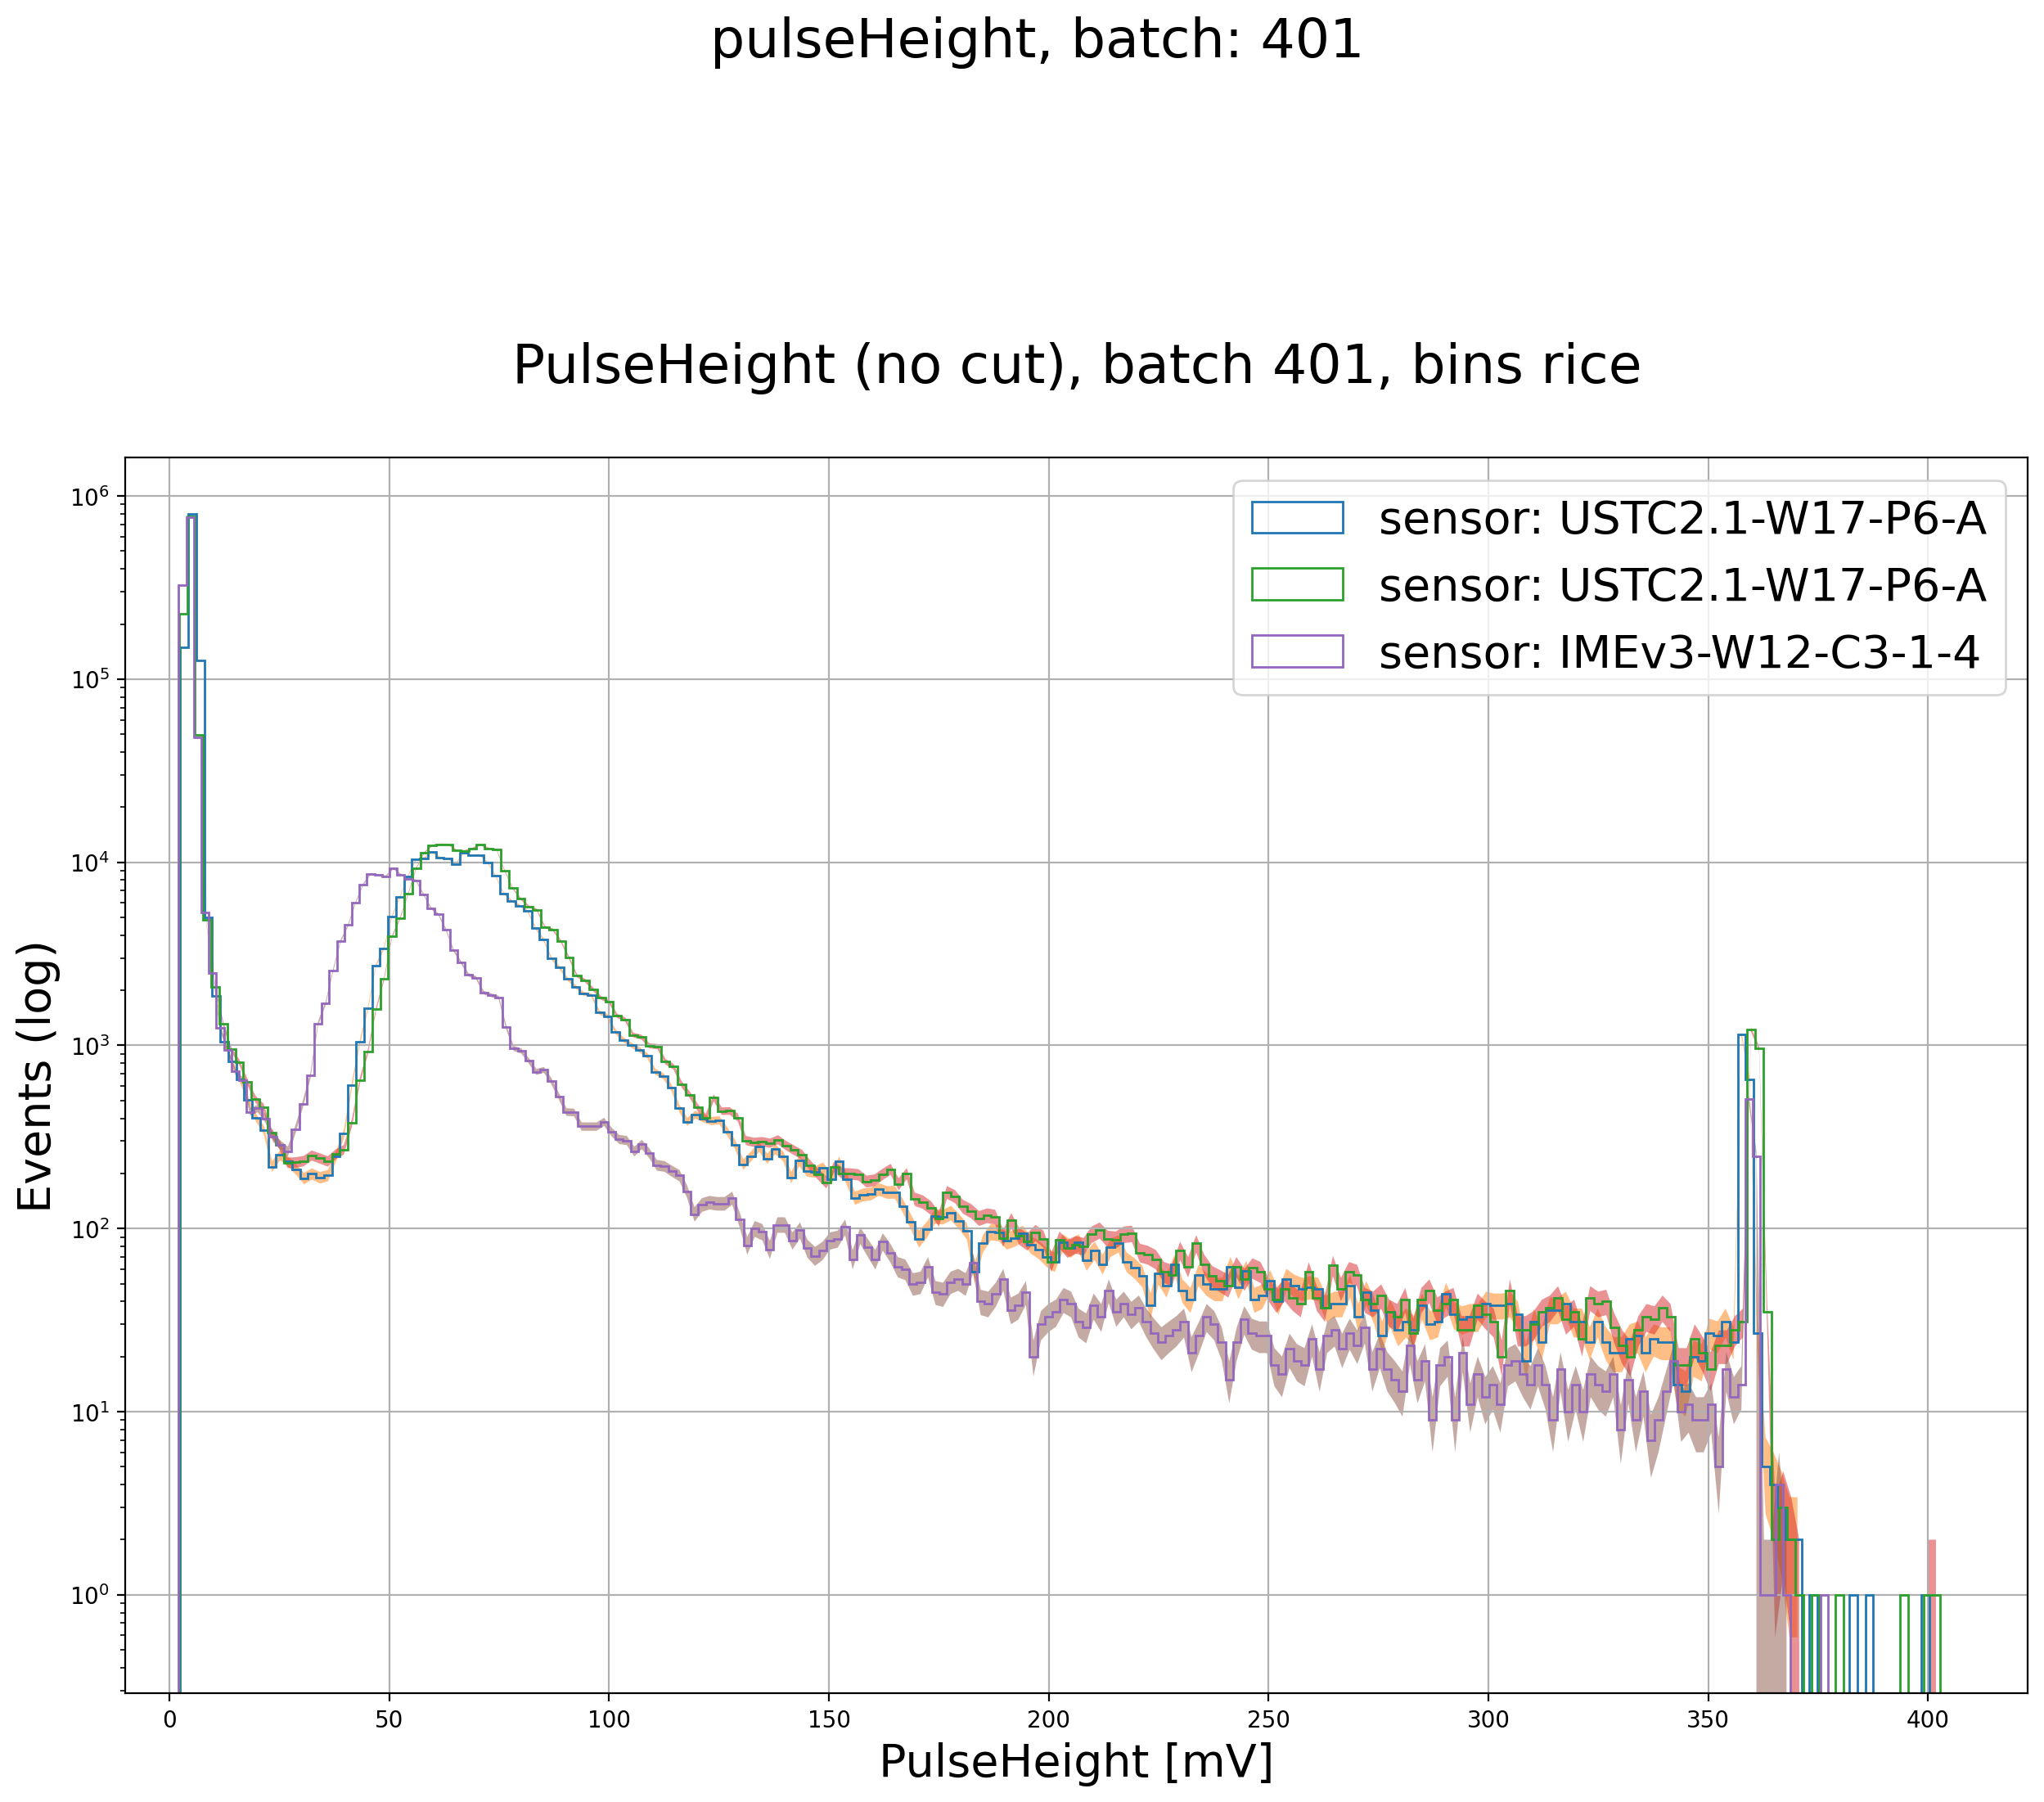

(<Figure size 3000x2000 with 1 Axes>,
 <AxesSubplot:title={'center':'PulseHeight (no cut), batch 401, bins rice'}, xlabel='PulseHeight [mV]', ylabel='Events (log)'>)

In [7]:
plot(df, "pulseHeight", dict_of_batches[this_batch], S)

DUT_1
DUT_2
DUT_3


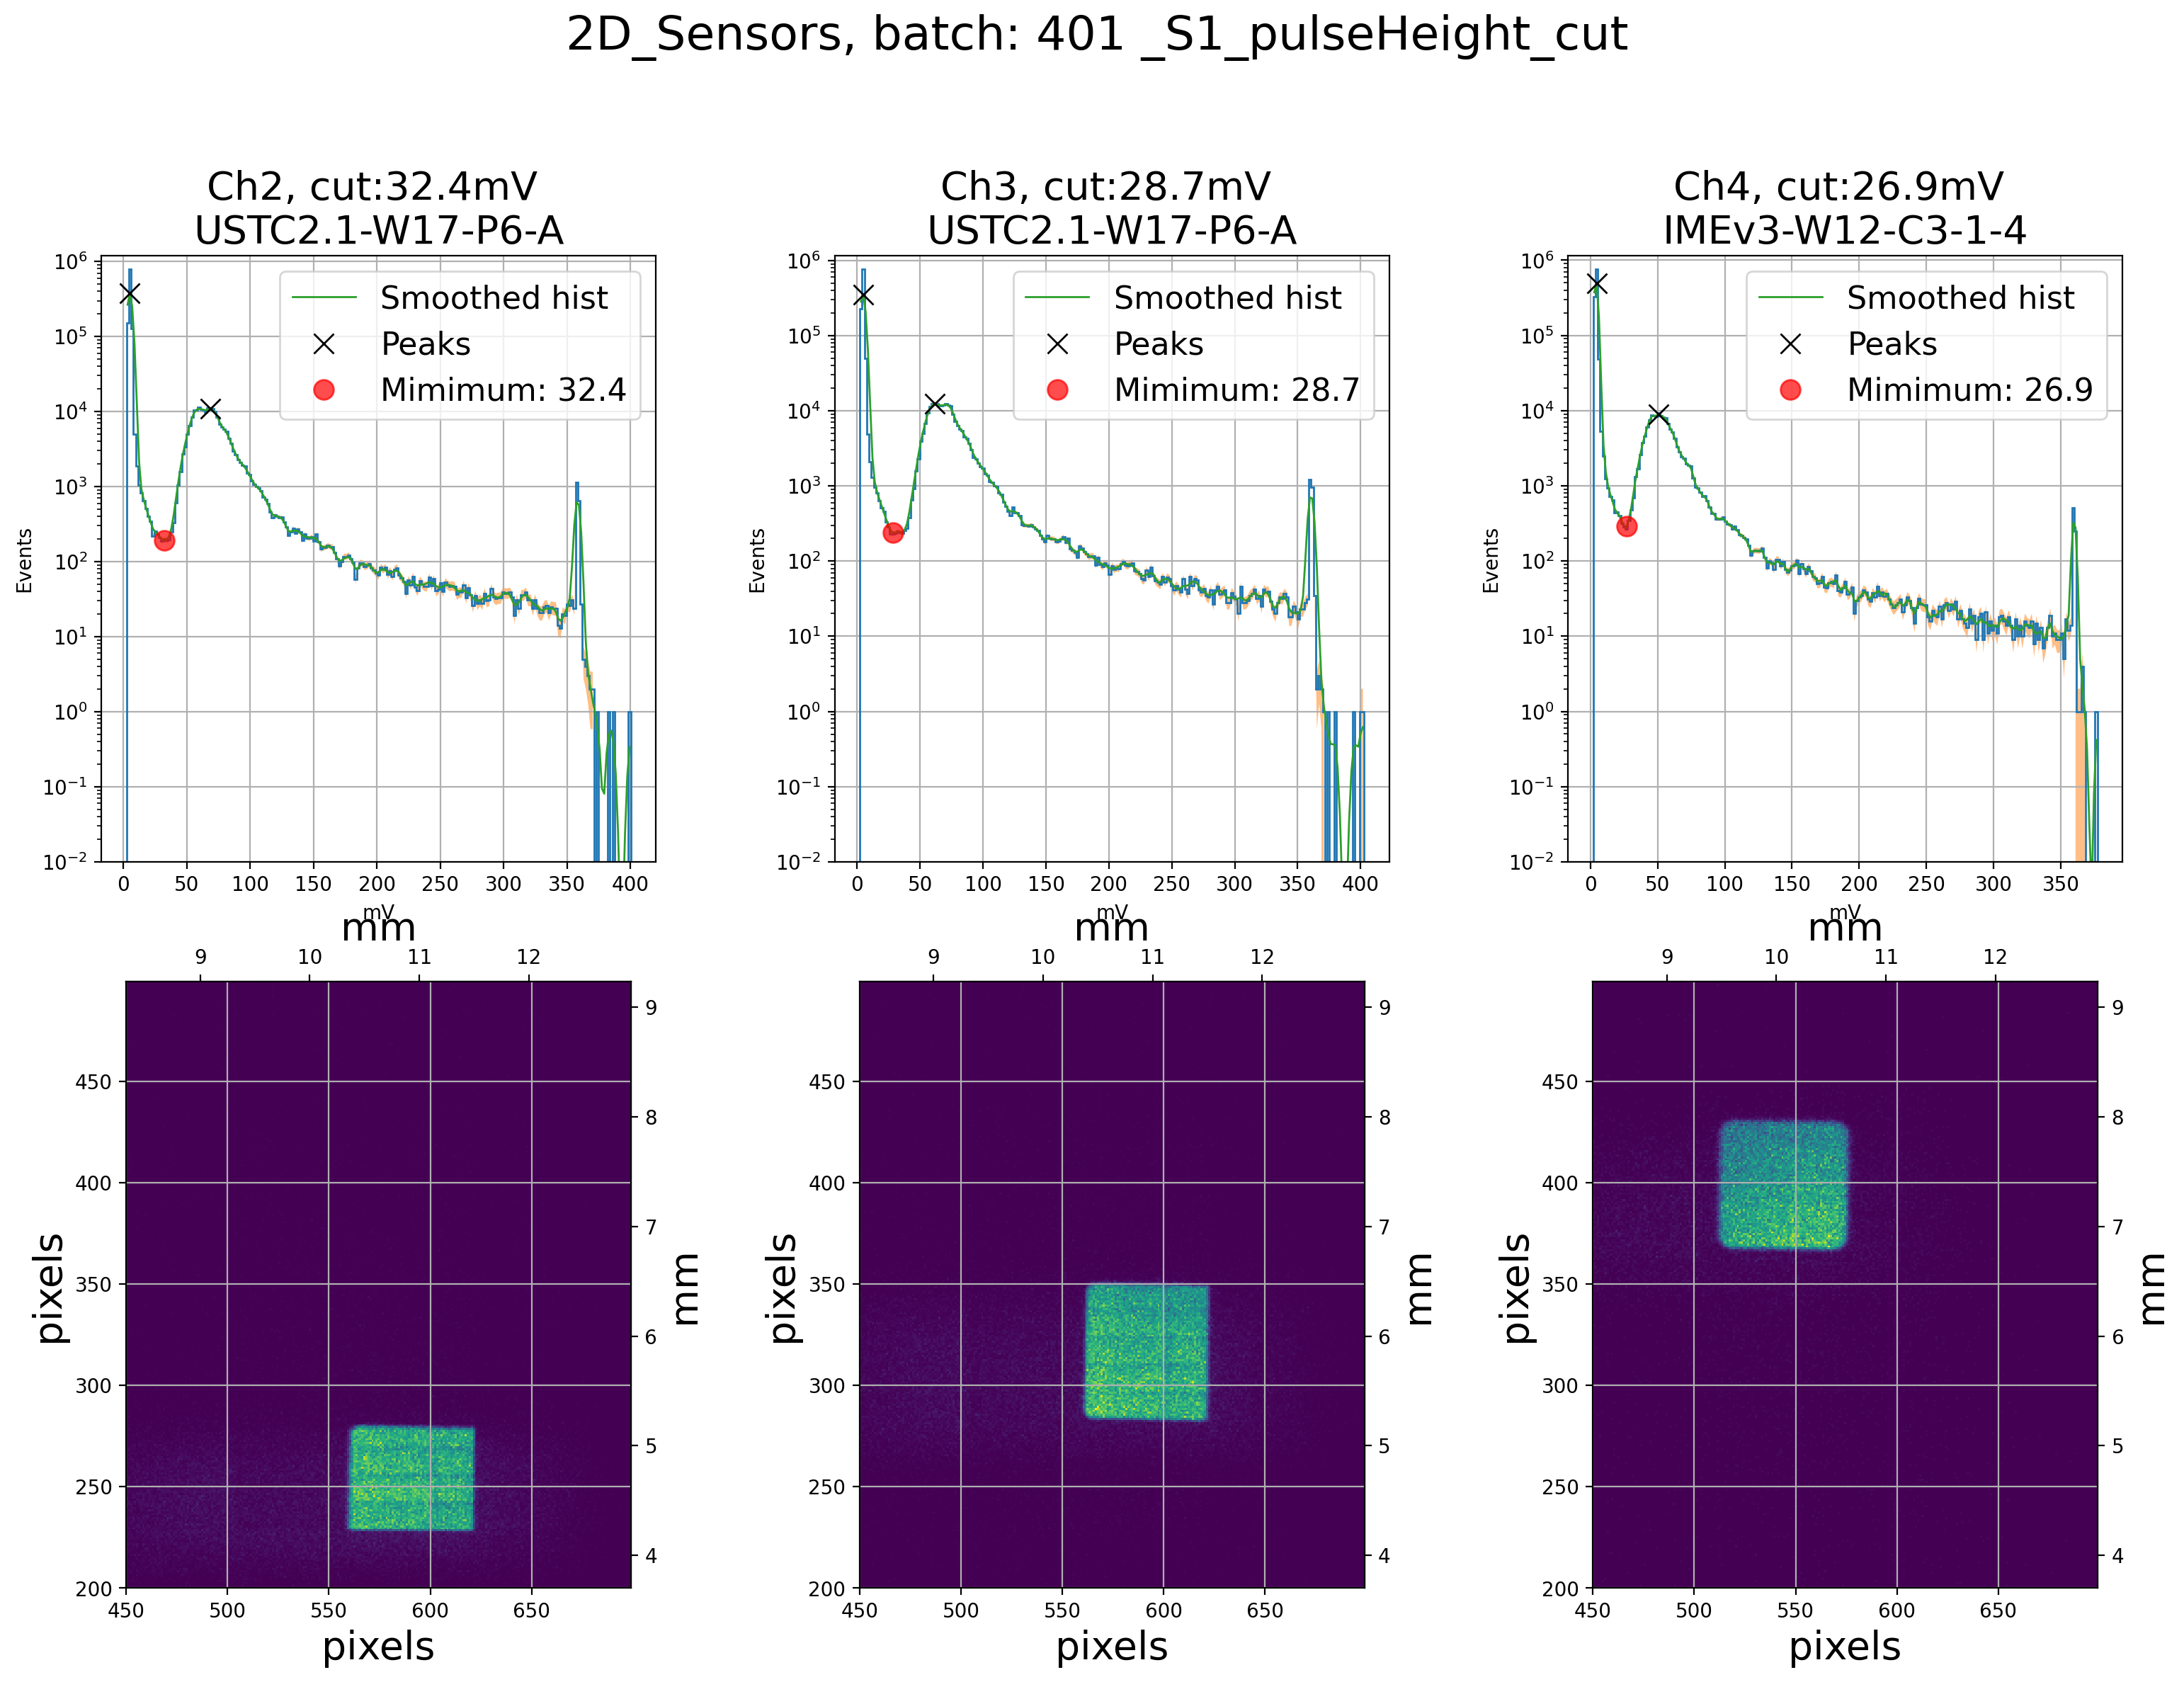

(<Figure size 3000x2000 with 6 Axes>,
 array([[<AxesSubplot:title={'center':'Ch2, cut:32.4mV \nUSTC2.1-W17-P6-A'}, xlabel='mV', ylabel='Events'>,
         <AxesSubplot:title={'center':'Ch3, cut:28.7mV \nUSTC2.1-W17-P6-A'}, xlabel='mV', ylabel='Events'>,
         <AxesSubplot:title={'center':'Ch4, cut:26.9mV \nIMEv3-W12-C3-1-4'}, xlabel='mV', ylabel='Events'>],
        [<AxesSubplot:xlabel='pixels', ylabel='pixels'>,
         <AxesSubplot:xlabel='pixels', ylabel='pixels'>,
         <AxesSubplot:xlabel='pixels', ylabel='pixels'>]], dtype=object))

In [8]:
plot(df, "2D_Sensors", dict_of_batches[this_batch], S, bins=bins1,
     n_DUT=DUTs, savefig=SAVE, savefig_details=f'_{S}_pulseHeight_cut', fmt='jpg')

### Use the Tracks with a pulseHeight cut to define the 'edges' of the sensor

In [9]:
### Calculate the mins in the pulseHeight cut
mins = [find_min_btw_peaks(df[f"pulseHeight_{i}"], bins='rice', plot=False) for i in range(1,4)]
mins.insert(0,None)     ### insert None as the 'peak' of the MCP

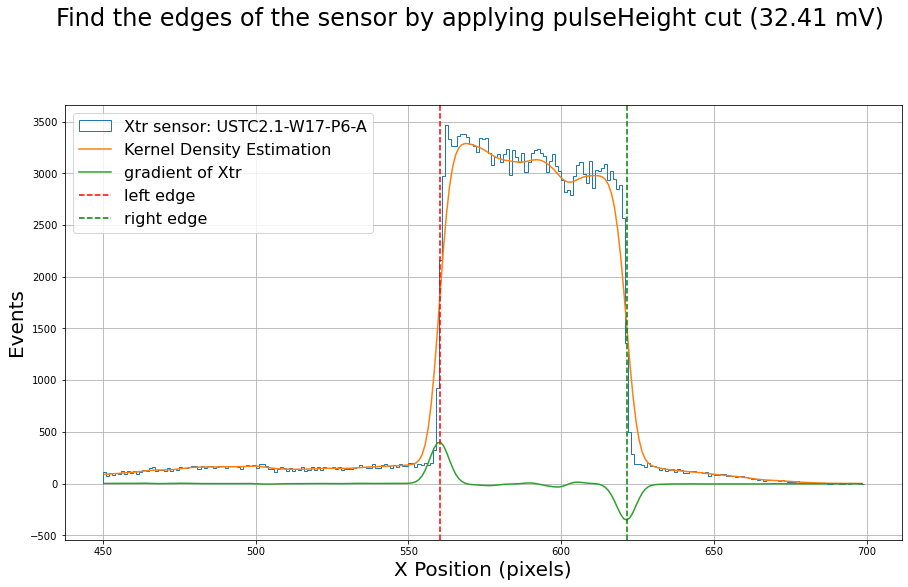

In [10]:
dut = 1
Xtr_cut = df[f'Xtr_{dut}'].loc[df[f'pulseHeight_{dut}']>mins[dut]]

fig, ax = plt.subplots(figsize=(15,8))
hist, my_bins, _ = ax.hist(Xtr_cut, bins=bins1[0], histtype='step', label=f"Xtr sensor: {dict_of_batches[this_batch].S[S].get_sensor(f'Ch{dut+1}').name}")

kde = gaussian_kde(Xtr_cut)
density_factor = sum(hist)*np.diff(my_bins)
bins_centers = (my_bins[1:]+my_bins[:-1])/2
values = time_limited_kde_evaluate(kde, bins_centers)*density_factor
ax.plot(bins_centers,values, label="Kernel Density Estimation")
ax.plot(bins_centers, np.gradient(values), label='gradient of Xtr')

left_edge = bins_centers[np.argmax(np.gradient(values))]
right_edge = bins_centers[np.argmin(np.gradient(values))]

ax.axvline(left_edge, color='r', linestyle='--', label='left edge')
ax.axvline(right_edge, color='g', linestyle='--', label='right edge')
fig.suptitle("Find the edges of the sensor by applying pulseHeight cut (%.2f mV)"%mins[dut], fontsize=24, y=1.05)

ax.set_xlabel("X Position (pixels)", fontsize=20)
ax.set_ylabel("Events", fontsize=20)
ax.grid('--')
ax.legend(fontsize=16, loc='upper left')

# fig.savefig(f"../various plots/locating_edges_Xtr_batch_{this_batch}_{this_scope}_DUT{dut}.svg")

## Geometry cut
I can now use the previous result as a definition for the geometry cut

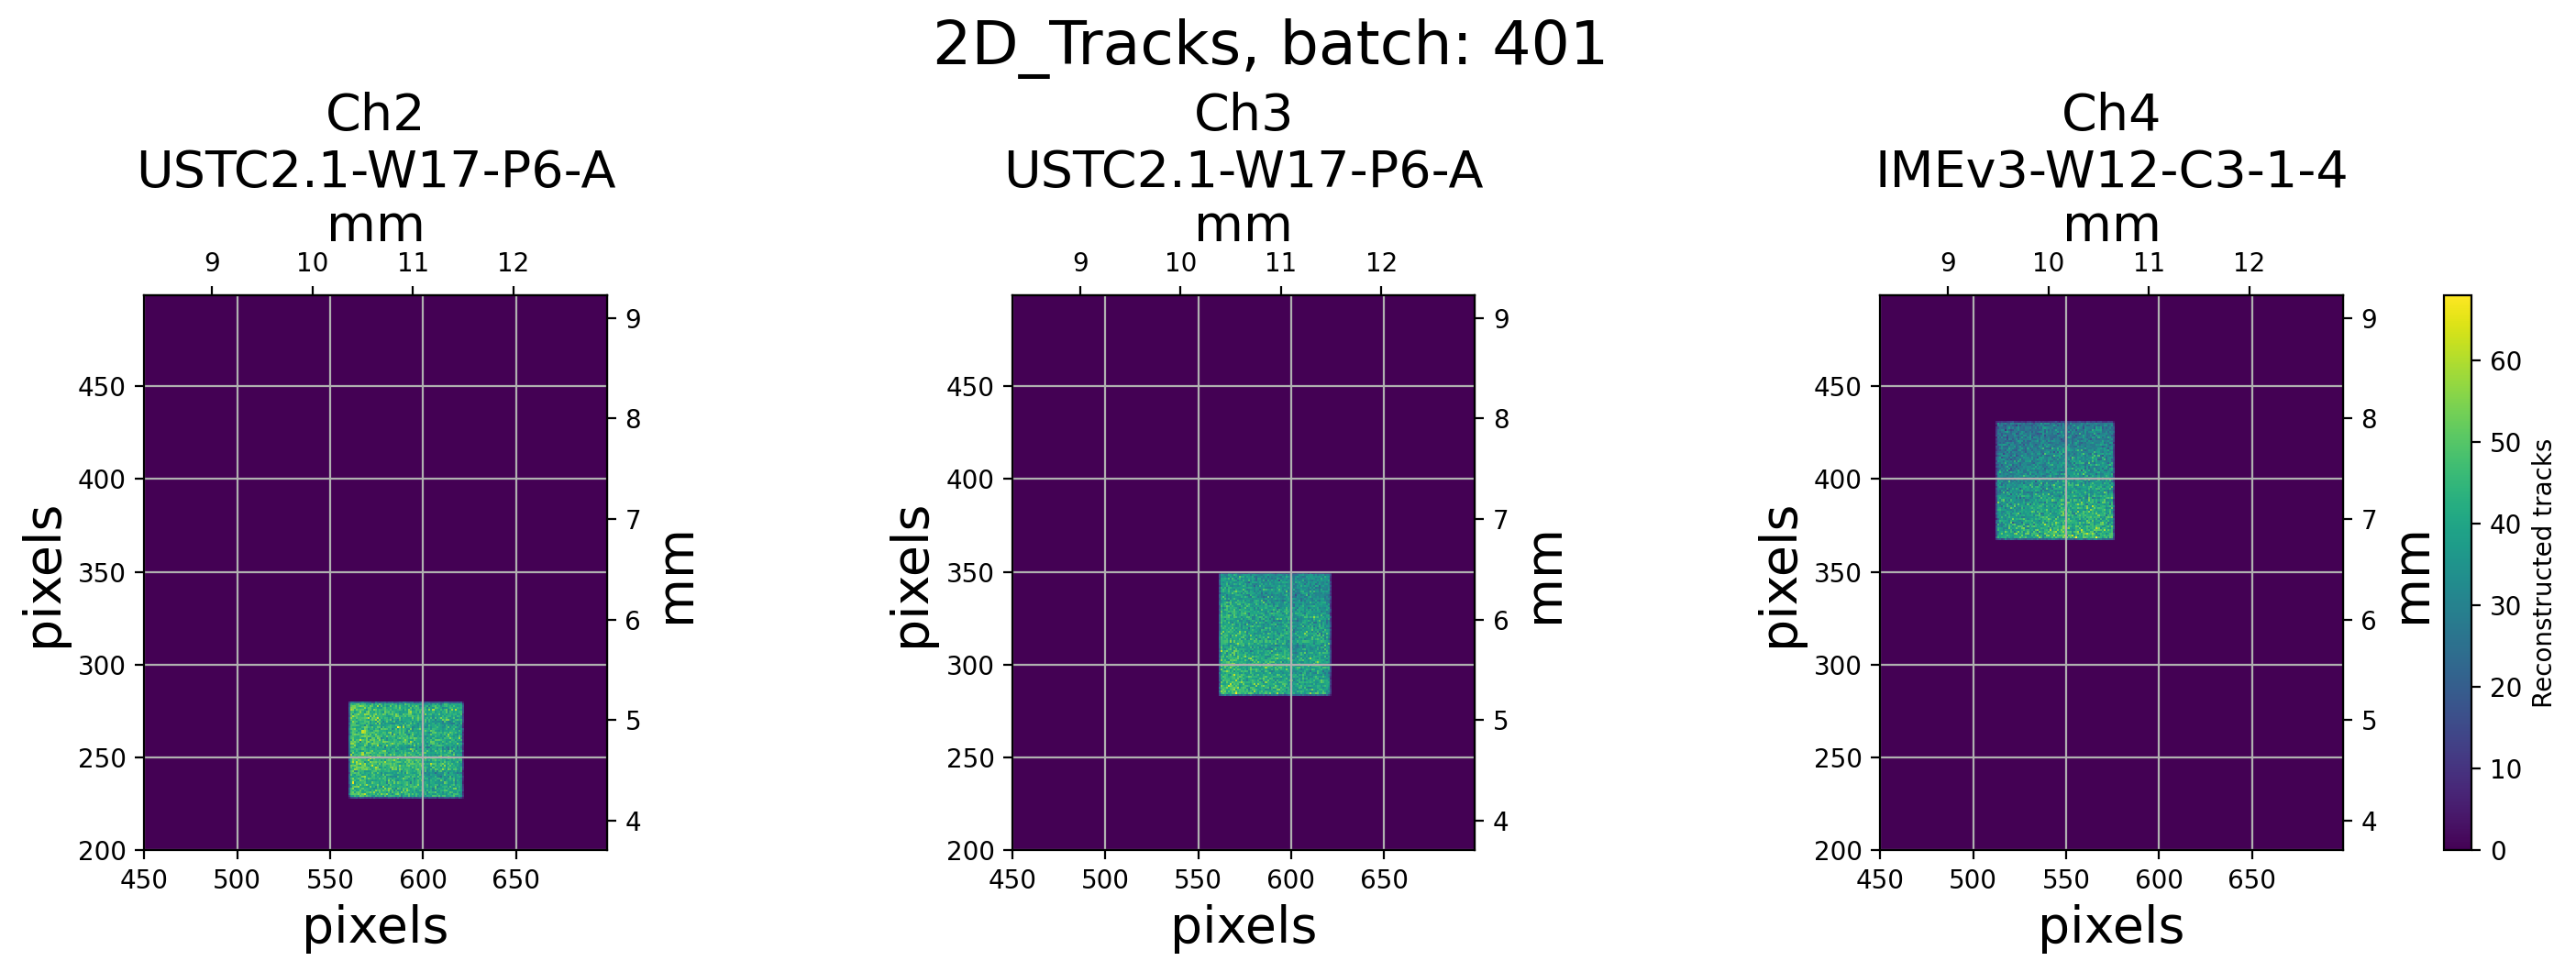

(<Figure size 3000x1000 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\nUSTC2.1-W17-P6-A'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch3\nUSTC2.1-W17-P6-A'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch4\nIMEv3-W12-C3-1-4'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

In [11]:
geo_cuts = [geometry_mask(df, bins1, 'rice', dut)[0] for dut in DUTs]

plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, mask=geo_cuts,
     n_DUT=DUTs, savefig=SAVE)

### Geometry cut AND pulseHeight cut


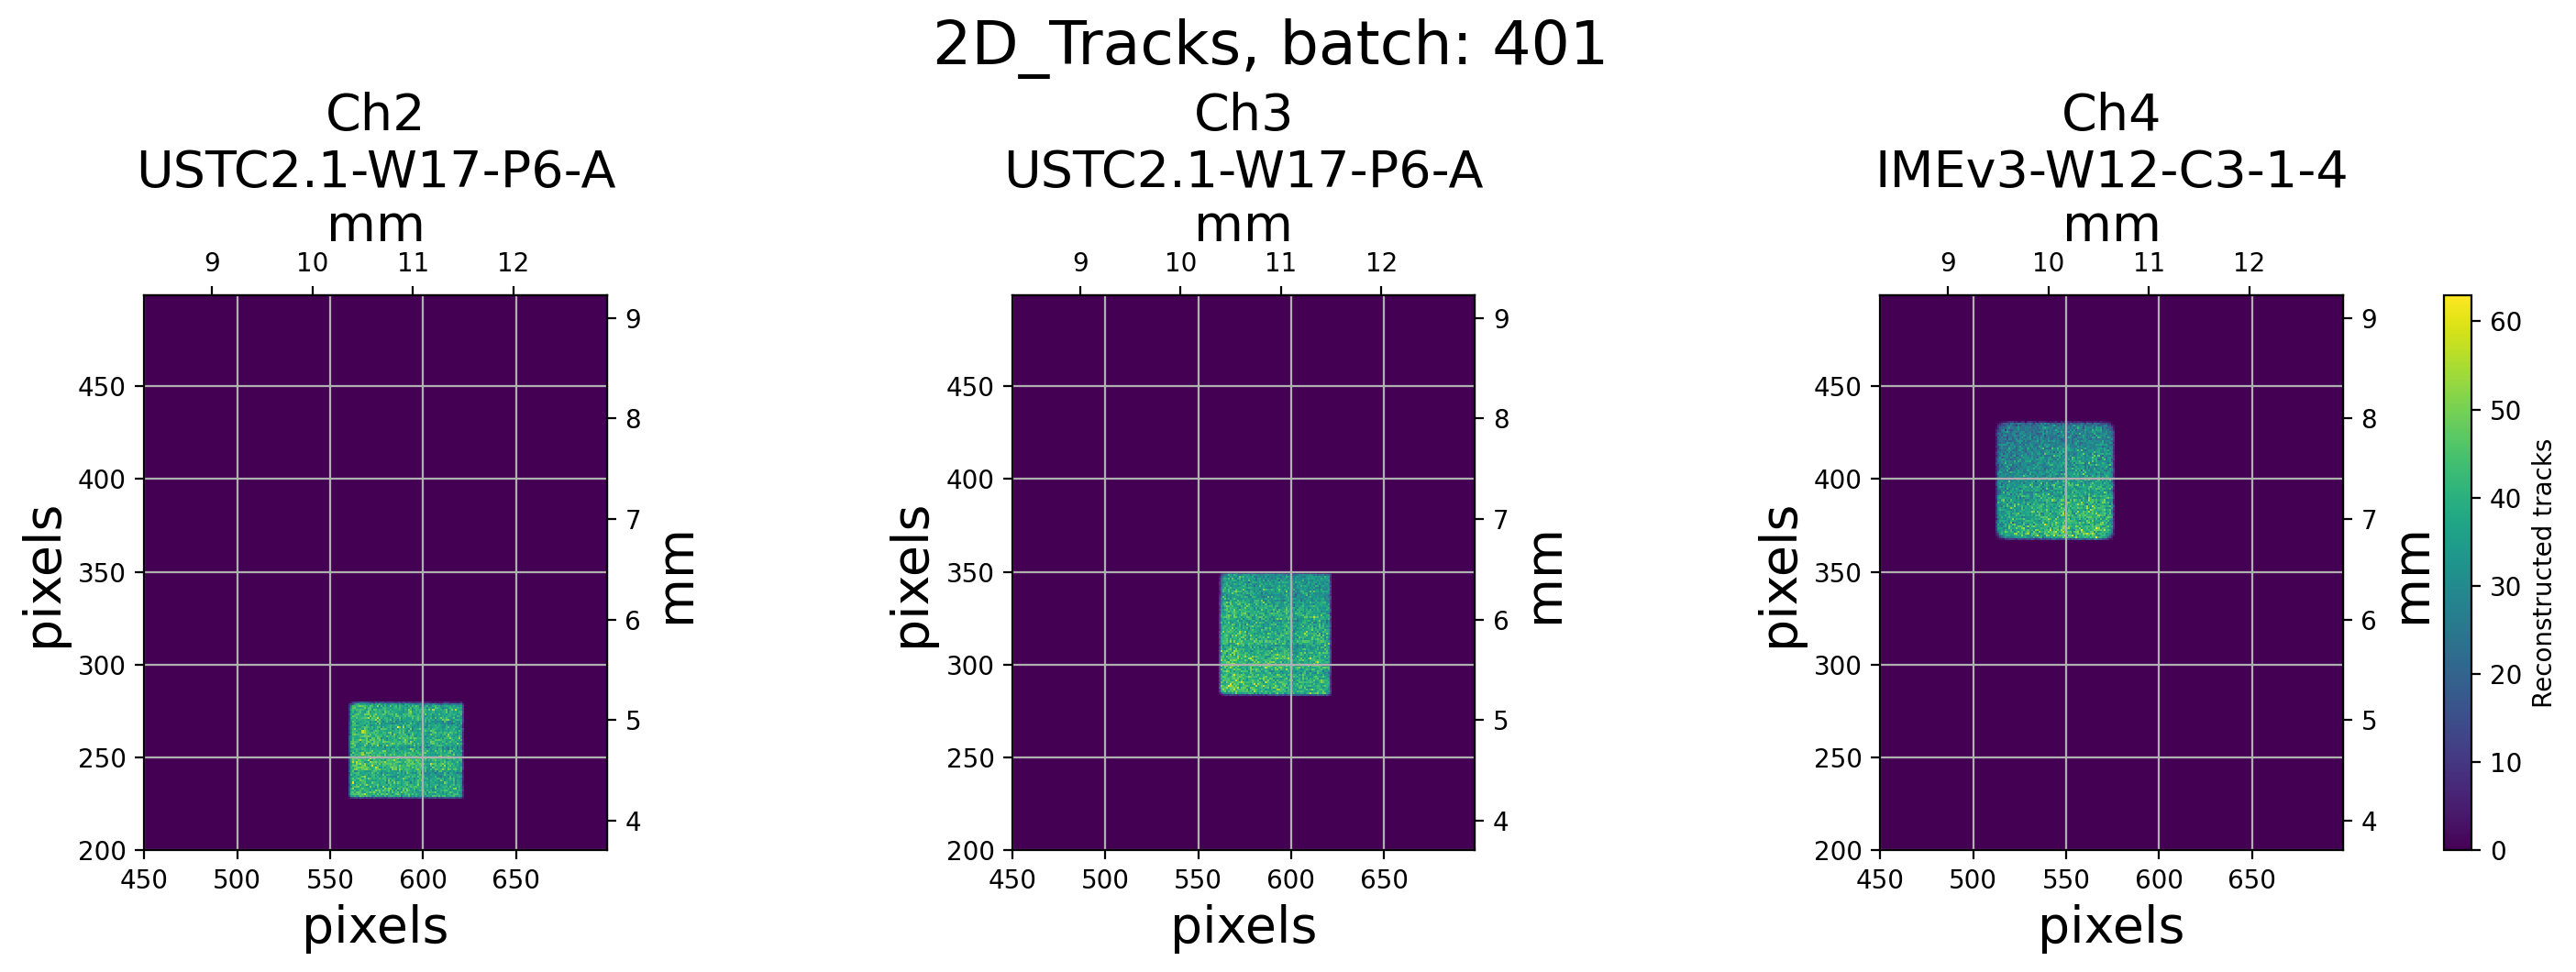

(<Figure size 3000x1000 with 4 Axes>,
 array([<AxesSubplot:title={'center':'Ch2\nUSTC2.1-W17-P6-A'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch3\nUSTC2.1-W17-P6-A'}, xlabel='pixels', ylabel='pixels'>,
        <AxesSubplot:title={'center':'Ch4\nIMEv3-W12-C3-1-4'}, xlabel='pixels', ylabel='pixels'>],
       dtype=object))

In [12]:
pulse_cuts = [df[f"pulseHeight_{dut}"]>mins[dut] for dut in DUTs]
pulse_geo = [np.logical_and(geo_cuts[i],pulse_cuts[i]) for i,dut in enumerate(DUTs)]

plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, mask=pulse_geo,
     n_DUT=DUTs, savefig=SAVE)

### With the options to:
- selecting a slightly larger area to study the outer part
- selecting only the center, to get the clearest signal 

In [13]:
# geo_cuts = [geometry_mask(df, bins1, 'rice', dut, only_select='extended')[0] for dut in DUTs]

# plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, mask=geo_cuts,
#      n_DUT=DUTs, savefig=SAVE)

In [14]:
# geo_cuts = [geometry_mask(df, bins1, 'rice', dut, only_select='center')[0] for dut in DUTs]

# plot(df,"2D_Tracks", dict_of_batches[this_batch], S, bins=bins1, mask=geo_cuts,
#      n_DUT=DUTs, savefig=SAVE)

## Next option: time cut
Fit the $\Delta t$ with a gaussian, pick 4 $\sigma$ interval and select events only in this window
Apply the fit from -20ns to +20ns so that the background is more flat
- also add full time range

### Gaussian:
$$
\Large
f(x,A,\mu,\sigma,BG) = A \cdot e^{-\frac{1}{2}\left(\frac{x-\mu}{\sigma} \right)^2} + BG
$$

- $A:  \quad $ Amplitude (n° of events)
- $\mu: \quad $ Mean of the gaussian
- $\sigma: \quad $ Standard deviation
- $BG: \quad $  Flat background

Text(0.5, 0.95, 'Time difference \n Batch: 401, Oscilloscope: S1')

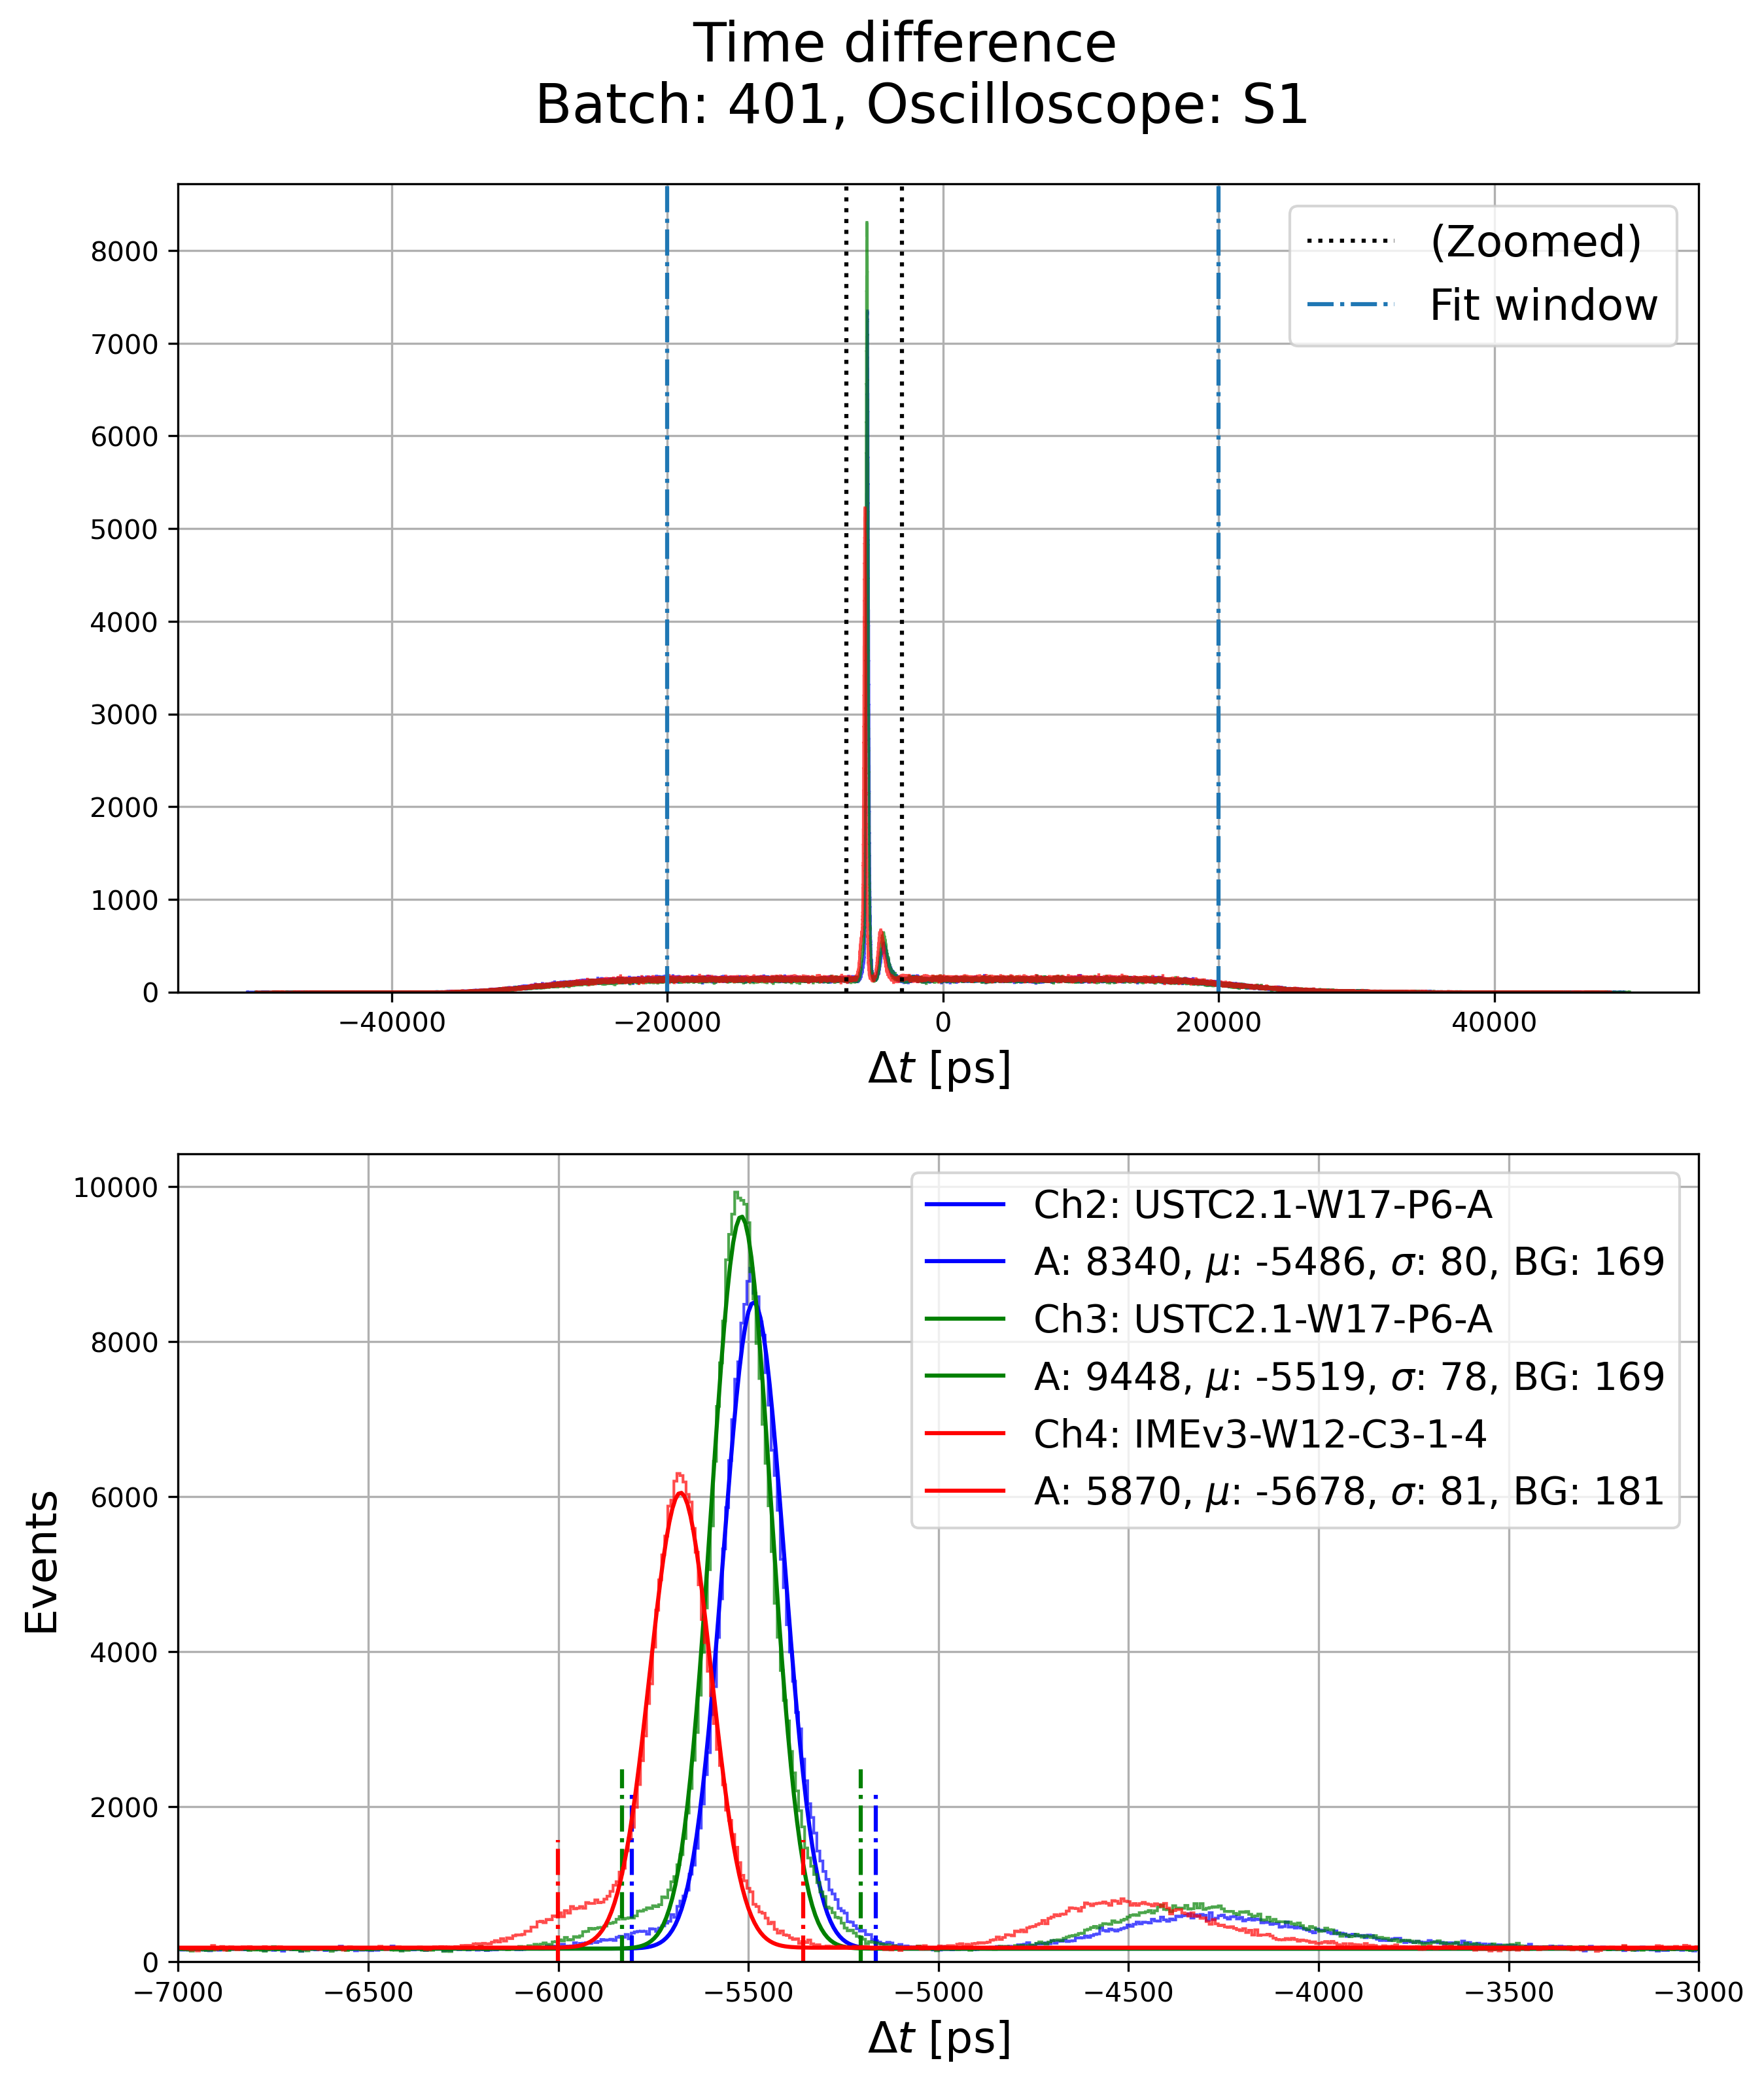

In [59]:
### SAME THING BUT ONLY FIRST PLOT
### now I fit between -20ns < delta t < 20ns
colormap = ['k','b','g','r']

fig, axes = plt.subplots(figsize=(10,12),nrows=2, ncols=1, dpi=300)

for dut in [1,2,3]:
    window_limit = 20e3
    window_fit = np.logical_and((df[f"timeCFD50_{dut}"]-df["timeCFD20_0"])> -window_limit,
                               (df[f"timeCFD50_{dut}"]-df["timeCFD20_0"])< +window_limit)
    
    plot_histogram((df[f"timeCFD50_{dut}"]-df["timeCFD20_0"]),
                   bins=15000, color=colormap[dut], linewidth=1, alpha=0.7,
                   fig_ax=(fig,axes[0]))
    
    
    hist, my_bins,_,_,_ = plot_histogram((df[f"timeCFD50_{dut}"].loc[window_fit]-df["timeCFD20_0"].loc[window_fit]),
                                         bins=5000, color=colormap[dut], linewidth=1, alpha=0.7,
                                         fig_ax=(fig,axes[1]))

    bins_centers = (my_bins[:-1]+my_bins[1:])/2
    initial_param = (np.max(hist),bins_centers[np.argmax(hist)],100,np.average(hist))
    param, covar = curve_fit(my_gauss, bins_centers, hist, p0=initial_param)#, sigma=hist**0.5, absolute_sigma=True)
#     print(f"Fit parameters: {param}")
    axes[1].plot(bins_centers, my_gauss(bins_centers,*param), color=colormap[dut],
              label=f"Ch{dut+1}: {dict_of_batches[this_batch].S[S].get_sensor(f'Ch{dut+1}').name}")
    number_of_sigmas = 4
    left_base, right_base = param[1]-number_of_sigmas*param[2], param[1]+number_of_sigmas*param[2]
    axes[1].vlines(left_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    axes[1].vlines(right_base, ymin=0, ymax=np.max(hist)/4, color=colormap[dut], linestyle='-.')
    ### add units to the parameters
    axes[1].plot([],[],color=colormap[dut], label="A: %.0f, $\mu$: %.0f, $\sigma$: %.0f, BG: %.0f" %(param[0],param[1], param[2], param[3])) # only two decimals

xlim = (-7e3,-3e3)    
axes[0].set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes[1].set_ylabel("Events", fontsize=16)
axes[0].axvline(xlim[0],linestyle=':',color='k',label='(Zoomed)')
axes[0].axvline(xlim[1],linestyle=':',color='k')
axes[0].axvline(-window_limit, linestyle='-.', label='Fit window')
axes[0].axvline(+window_limit, linestyle='-.')
axes[0].legend(fontsize=16)

axes[1].set_xlabel(f"$\Delta t$ [ps]", fontsize=16)
axes[1].set_ylabel("Events", fontsize=16)
axes[1].set_xlim(xlim)
axes[1].legend(fontsize=14)

fig.suptitle(f"Time difference \
\n Batch: {this_batch}, Oscilloscope: {S}",y=.95, fontsize=20)
# fig.savefig(f"../various plots/time_difference_{this_batch}_{S}_small_range_with_fit.svg")

parenthesis about the second/third peak in the $\Delta t$

- charge calculations
- efficiency plots